# Content Placement in 5G-enabled Edge/Core Datacenter Networks Resilient to Link Cut Attacks

Carlos Natalino, Amaro de Sousa, Lena Wosinska and Marija Furdek

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import islice
from matplotlib import gridspec
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import reader

markers = ['o', 's', '^', 'v']
lines = [':', '--', '-']
colors = rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 20
# rcParams['font.weight'] = 2
rcParams['lines.markersize'] = 7.0
rcParams['text.usetex'] = False
rcParams['mathtext.fontset'] = 'custom'

### Load results

In [2]:
folder = 'data'

# select the topology to be processed
# topology = 'Coronet'
topology = 'Germany50'

fig_size = {}
fig_size['Coronet'] = (9, 6)
fig_size['Germany50'] = (6, 8)

fig_size_plots = (10, 6)

figure_format = 'svg'

data_cpp_4 = pd.read_csv(folder + '/sol-placement-' + topology + '-full-5000-4.0.csv', sep='\t')
data_cpp_5 = pd.read_csv(folder + '/sol-placement-' + topology + '-full-5000-5.0.csv', sep='\t')
data_cpp_6 = pd.read_csv(folder + '/sol-placement-' + topology + '-full-5000-6.0.csv', sep='\t')

data_cpp_full = pd.concat([data_cpp_4, data_cpp_5, data_cpp_6]).reset_index(drop=True)

data_clsd_4 = pd.read_csv(folder + '/sol-clsd-' + topology + '-full-5000-4.0.csv', sep='\t')
data_clsd_5 = pd.read_csv(folder + '/sol-clsd-' + topology + '-full-5000-5.0.csv', sep='\t')
data_clsd_6 = pd.read_csv(folder + '/sol-clsd-' + topology + '-full-5000-6.0.csv', sep='\t')

data_clsd_full = pd.concat([data_clsd_4, data_clsd_5, data_clsd_6]).reset_index(drop=True)

del data_cpp_4, data_cpp_5, data_cpp_6, data_clsd_4, data_clsd_5, data_clsd_6

data_cpp_only_dcs = pd.read_csv(folder + '/sol-placement-' + topology + '-only-dcs.csv', sep='\t')

data_clsd_only_dcs = pd.read_csv(folder + '/sol-clsd-' + topology + '-only-dcs.csv', sep='\t')

costs_edc_unique = data_cpp_full.groupby(['cost_edc_0', 'cost_edc_1', 'cost_edc_2']).size()
cost_configurations = []
for key in costs_edc_unique.keys():
    cost_configurations.append(key)
    
p_unique = data_clsd_full.groupby(['p']).size()
ps = []
for key in p_unique.keys():
    ps.append(key)
ps_of_interest = [6, 9, 12]

num_nodes = np.count_nonzero([1 if col.startswith('dc_') else 0 for col in data_cpp_full.columns])

graph = reader.read_txt_file('./topologies/' + topology + '.txt')

In [3]:
print('budgets:', data_cpp_full['budget'].unique())
print('solutions:', data_cpp_full['id_solution'].max()+1)
print('placement and link detection numbers are', 'correct' if data_cpp_full['id_solution'].max() == data_clsd_full['id_solution'].max() else 'incorrect')
print('ps:', ps)
print('cost configurations:', cost_configurations)

budgets: [4. 5. 6.]
solutions: 5000
placement and link detection numbers are correct
ps: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
cost configurations: [(0.0, 0.1, 0.2), (0.0, 0.1, 0.4)]


# Generating Pareto frontier

### Computing Pareto frontier for all the cases

In [4]:
budgets = data_cpp_full.budget.unique()
min_distance = data_cpp_full['avg_distance'].min()

points_x_full = {}
points_y_full = {}
best_solutions_full = {}

for idb, budget in enumerate(budgets):
    points_x_full[budget] = {}
    points_y_full[budget] = {}
    best_solutions_full[budget] = {}
    for idc, cost_configuration in enumerate(cost_configurations):
        points_x_full[budget][cost_configuration] = {}
        points_y_full[budget][cost_configuration] = {}
        best_solutions_full[budget][cost_configuration] = {}
        for idp, p in enumerate(ps_of_interest): # for each number of critical links to be detected
            points_x_full[budget][cost_configuration][p] = []
            points_y_full[budget][cost_configuration][p] = []
            last_y = 0.0 # we initialize the mu-ACA as zero
            max_solutions = data_clsd_full[(data_clsd_full['budget'] == budget)
                              & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                              & (data_clsd_full['p'] <= p)]['id_solution'].max()
            for solution in range(max_solutions + 1): # for each solution of the RPP computed, i.e., we read in the order from the lowest to the highest average distance
                muaca = data_clsd_full[(data_clsd_full['budget'] == budget)
                              & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                              & (data_clsd_full['p'] <= p) 
                              & (data_clsd_full['id_solution'] == solution)]['aca'].mean()
                if muaca > last_y: # if the mu-ACA of this solution is higher than the highest one found so far, it means this solution is part of the Pareto front
                    best_solutions_full[budget][cost_configuration][p] = solution # this is so far the best solution
                    last_y = muaca
                    avg_distance = data_cpp_full[(data_cpp_full['budget'] == budget) 
                                            & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                            & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                            & (data_cpp_full['cost_edc_2'] == cost_configuration[2]) 
                                            & (data_cpp_full['id_solution'] == solution)]['avg_distance'].values[0]
                    # add distance and mu-ACA to the Pareto frontier data structures
                    points_x_full[budget][cost_configuration][p].append(avg_distance)
                    points_y_full[budget][cost_configuration][p].append(muaca)

            # we also add the last point, so that we can see what's the maximum distance explored by the model
            points_x_full[budget][cost_configuration][p].append(data_cpp_full[(data_cpp_full['budget'] == budget) 
                                        & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                        & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                        & (data_cpp_full['cost_edc_2'] == cost_configuration[2])]['avg_distance'].values[-1])
            points_y_full[budget][cost_configuration][p].append(last_y)

points_x_only_dcs = {}
points_y_only_dcs = {}
best_solution_only_dcs = {}

# here we have the same intuition, but for the model that only considers core data centers
for idb, budget in enumerate(budgets):
    points_x_only_dcs[budget] = {}
    points_y_only_dcs[budget] = {}
    best_solution_only_dcs[budget] = {}
    for idp, p in enumerate(ps_of_interest):
        points_x_only_dcs[budget][p] = []
        points_y_only_dcs[budget][p] = []
        last_y = 0.0
        max_solutions = data_clsd_only_dcs[(data_clsd_only_dcs['budget'] == budget)
                              & (data_clsd_only_dcs['p'] <= p)]['id_solution'].max()
        for solution in range(max_solutions + 1):
            muaca = data_clsd_only_dcs[(data_clsd_only_dcs['budget'] == budget) 
                              & (data_clsd_only_dcs['p'] <= p) 
                              & (data_clsd_only_dcs['id_solution'] == solution)]['aca'].mean()
            if muaca > last_y:
                best_solution_only_dcs[budget][p] = solution
                last_y = muaca
                avg_distance = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)  
                                            & (data_cpp_only_dcs['id_solution'] == solution)]['avg_distance'].values[0]
                points_x_only_dcs[budget][p].append(avg_distance)
                points_y_only_dcs[budget][p].append(muaca)
        points_x_only_dcs[budget][p].append(data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)]['avg_distance'].values[-1])
        points_y_only_dcs[budget][p].append(last_y)
            
print('done...')

done...


## Plotting topologies

### Plotting RPP solutions

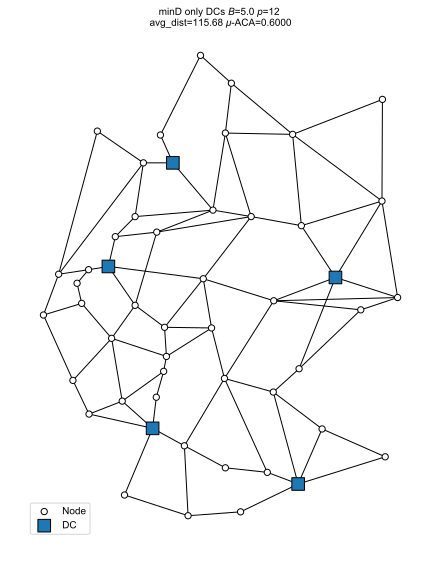

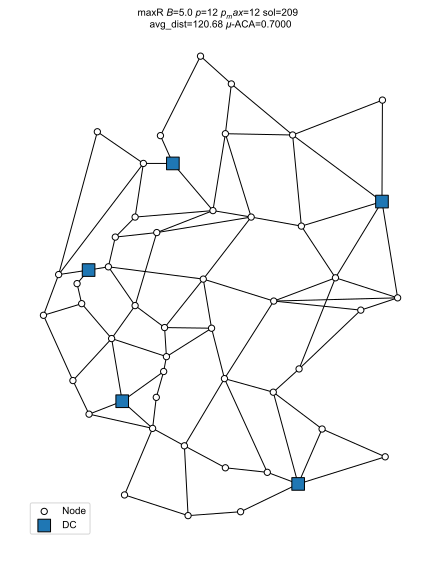

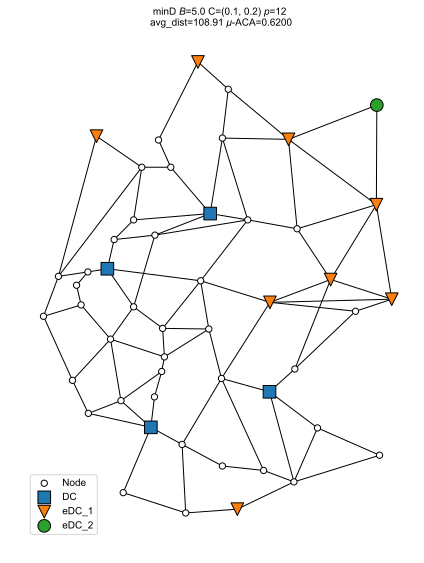

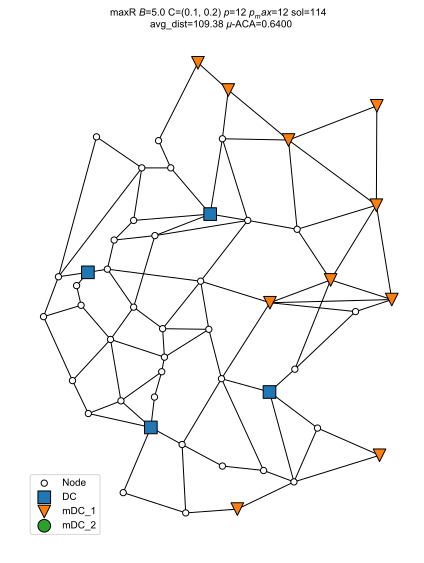

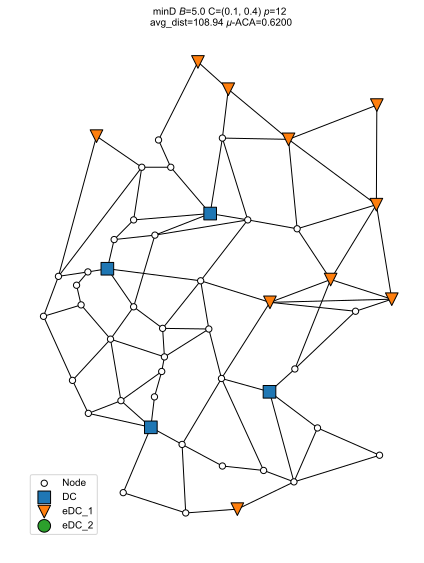

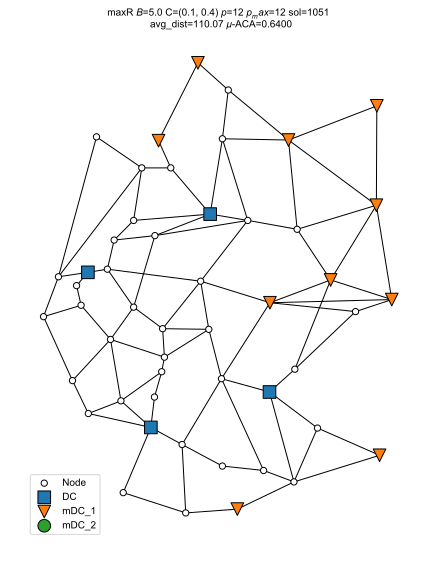

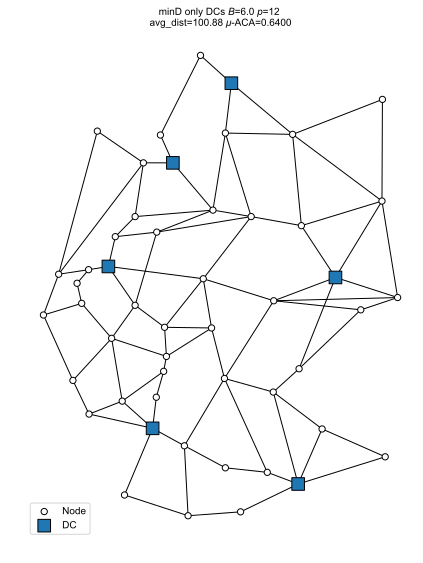

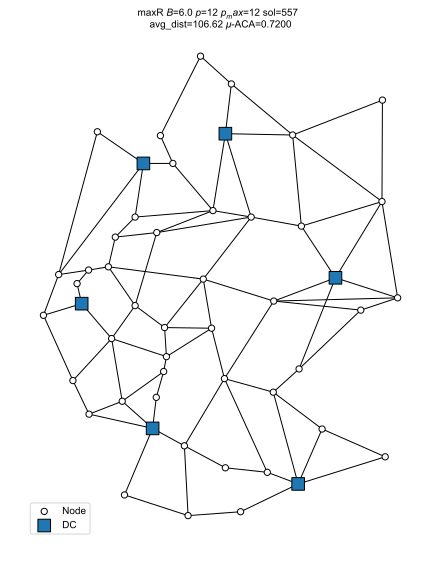

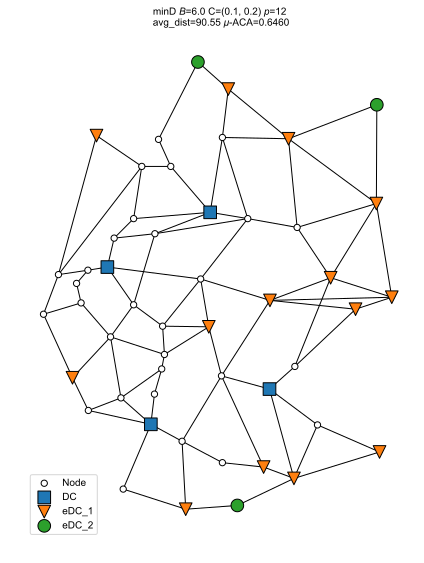

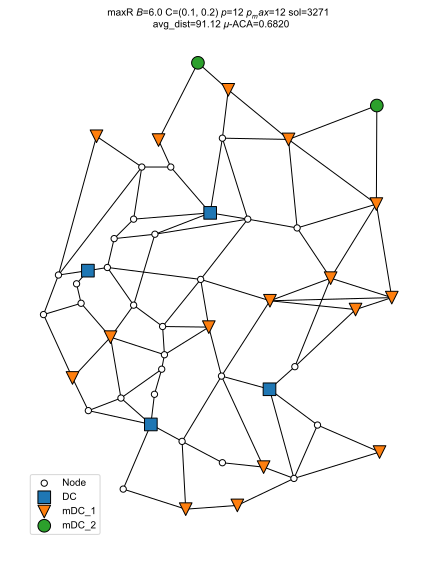

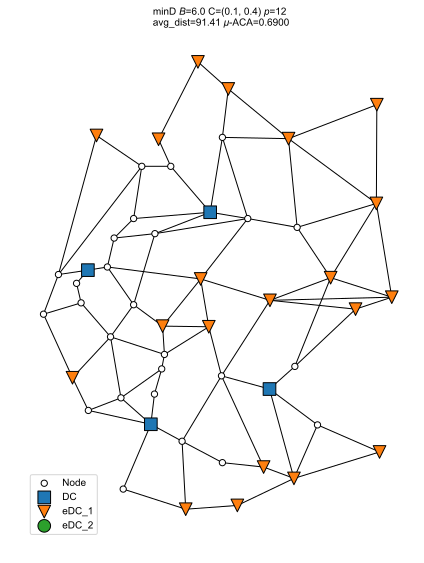

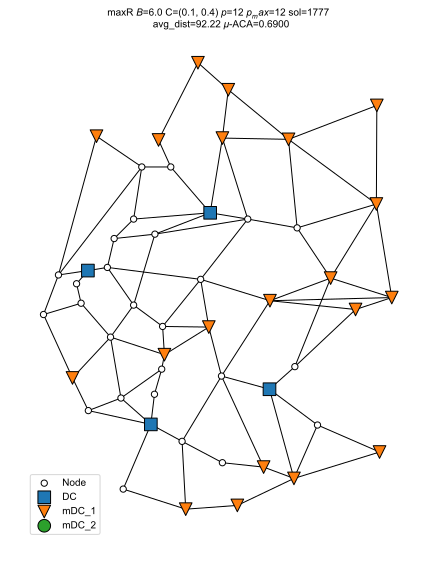

In [17]:
node_size = 160
line_width=1.0
critical_edge_style='dotted'
critical_edge_color='red'

for idb, budget in enumerate([5., 6.]):#budgets
    
    for idp, p in enumerate([12]):#ps_of_interest
        
        plt.figure(figsize=fig_size[topology])
        plt.axis('off')

        pos = nx.get_node_attributes(graph, 'pos')
        solution_cpp = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)].iloc[0]

        solution_clsd = data_clsd_only_dcs[(data_clsd_only_dcs['budget'] == budget) 
                                  & (data_clsd_only_dcs['p'] == p)
                                  & (data_clsd_only_dcs['id_solution'] == 0)].iloc[0]

        plt.title('minD only DCs $B$={} $p$={} \navg_dist={:.2f} $\mu$-ACA={:.4f}'.format(budget, p, solution_cpp['avg_distance'], solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])
            
        nx.draw_networkx_edges(graph, pos)
            
        # plotting transport nodes which are not critical
        # cn_X == 1 if the node still connected to a replica, 0 otherwise
        nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0]
        nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0]
        plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)
        
        # plotting non critical DCs
        nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
        nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
        plt.scatter(nodes_x, nodes_y, label='DC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

        plt.legend(loc=3)
        plt.tight_layout()
#         plt.savefig('./figures/topology-rpp-' + topology + '-only-DCs-B_' + str(budget) + '-p_' + str(p) + '-minD.' + figure_format)
        plt.show()
        plt.close()
        
        for idpmax, pmax in enumerate([12]):#ps_of_interest
        
            plt.figure(figsize=fig_size[topology])
            plt.axis('off')

            pos = nx.get_node_attributes(graph, 'pos')
            solution_cpp = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)
                                            & (data_cpp_only_dcs['id_solution'] == best_solution_only_dcs[budget][pmax])].iloc[0]
            
            solution_clsd = data_clsd_only_dcs[(data_clsd_only_dcs['budget'] == budget) 
                                  & (data_clsd_only_dcs['p'] == p)
                                  & (data_clsd_only_dcs['id_solution'] == best_solution_only_dcs[budget][pmax])].iloc[0]

            plt.title('maxR $B$={} $p$={} $p_max$={} sol={}  \navg_dist={:.2f} $\mu$-ACA={:.4f}'.format(budget, p, pmax, best_solution_only_dcs[budget][pmax], solution_cpp['avg_distance'], solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])

            nx.draw_networkx_edges(graph, pos)

            # plotting transport nodes which are not critical
            # cn_X == 1 if the node still connected to a replica, 0 otherwise
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0]
            plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)

            # plotting non critical DCs
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            plt.scatter(nodes_x, nodes_y, label='DC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

            plt.legend(loc=3)
            plt.tight_layout()
#             plt.savefig('./figures/topology-rpp-' + topology + '-only-DCs-B_' + str(budget) + '-p_max_' + str(pmax) + '-maxR.' + figure_format)
            plt.show()
            plt.close()
        
        for idc, cost_configuration in enumerate(cost_configurations):
    
            plt.figure(figsize=fig_size[topology])
            plt.axis('off')

            pos = nx.get_node_attributes(graph, 'pos')
            solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget) 
                              & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_cpp_full['cost_edc_2'] == cost_configuration[2])].iloc[0]
            
            solution_clsd = data_clsd_full[(data_clsd_full['budget'] == budget) 
                              & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                              & (data_clsd_full['p'] == p)].iloc[0]
            plt.title('minD $B$={} C={} $p$={} \navg_dist={:.2f} $\mu$-ACA={:.4f}'.format(budget, cost_configuration[1:], p, solution_cpp['avg_distance'], solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])

            nx.draw_networkx_edges(graph, pos)
            
            # plotting transport nodes which are not critical
            # cn_X == 1 if the node still connected to a replica, 0 otherwise
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1]
            plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)

            # plotting non critical DCs
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            plt.scatter(nodes_x, nodes_y, label='DC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

            plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1],
                       [pos[x][1] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1], label='eDC_1', color=colors[1], alpha=1., marker='v', linewidths=1., edgecolors='black', s=node_size)

            plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1],
                       [pos[x][1] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1], label='eDC_2', color=colors[2], alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size)
            
            plt.legend(loc=3)
            plt.tight_layout()
#             plt.savefig('./figures/topology-rpp-' + topology + '-full-B_' + str(budget) + '-C_' + str(cost_configuration[1:]).replace(',', '_').replace('(', '-').replace(')', '-') + '-p_' + str(p) + '-minD.' + figure_format)
            plt.show()
            plt.close()
            
            for idpmax, pmax in enumerate([12]):#ps_of_interest
            
                plt.figure(figsize=fig_size[topology])
                plt.axis('off')

                pos = nx.get_node_attributes(graph, 'pos')
                solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget) 
                                  & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                  & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                  & (data_cpp_full['cost_edc_2'] == cost_configuration[2])
                                  & (data_cpp_full['id_solution'] == best_solutions_full[budget][cost_configuration][pmax])].iloc[0]

                solution_clsd = data_clsd_full[(data_clsd_full['budget'] == budget) 
                                  & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                                  & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                                  & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                                  & (data_clsd_full['p'] == p)
                                  & (data_clsd_full['id_solution'] == best_solutions_full[budget][cost_configuration][pmax])].iloc[0]
                plt.title('maxR $B$={} C={} $p$={} $p_max$={} sol={}  \navg_dist={:.2f} $\mu$-ACA={:.4f}'.format(budget, cost_configuration[1:], p, pmax, best_solutions_full[budget][cost_configuration][pmax], solution_cpp['avg_distance'], solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])

                nx.draw_networkx_edges(graph, pos)

                nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1]
                nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1]
                plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)
            
                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1], label='DC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1], label='mDC_1', color=colors[1], alpha=1., marker='v', linewidths=1., edgecolors='black', s=node_size)

                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1], label='mDC_2', color=colors[2], alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size)
                plt.legend(loc=3)
                plt.tight_layout()
#                 plt.savefig('./figures/topology-rpp-' + topology + '-full-B_' + str(budget) + '-C_' + str(cost_configuration[1:]).replace(',', '_').replace('(', '-').replace(')', '-') + '-p_' + str(p) + '-pmax_' + str(pmax) + '-maxR.' + figure_format)
                plt.show()
                plt.close()

### Plotting CLSD solutions

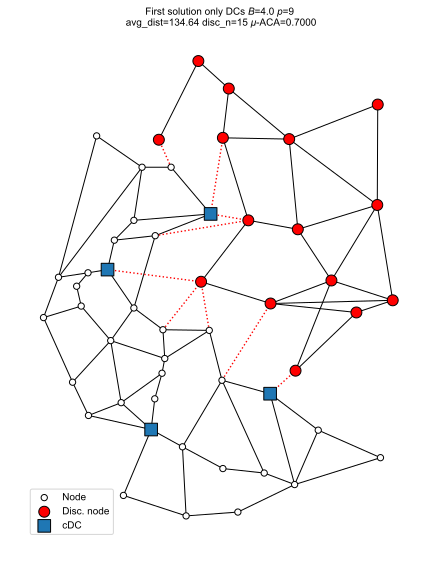

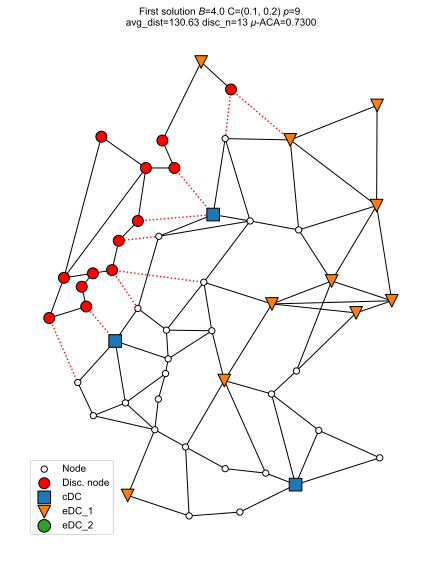

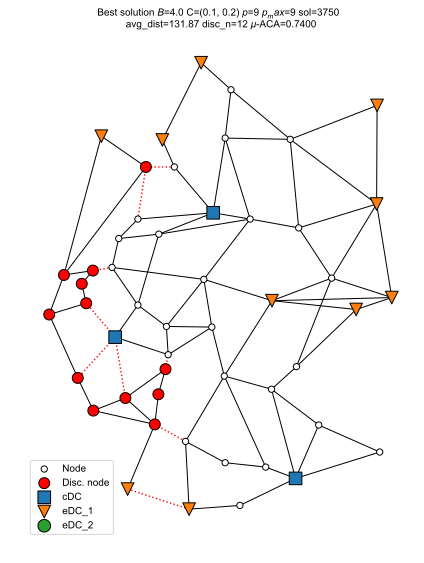

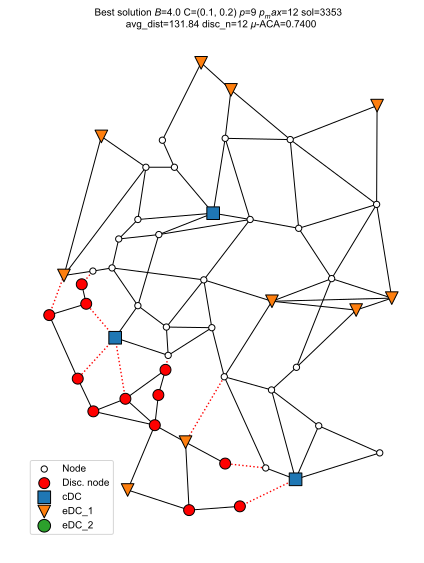

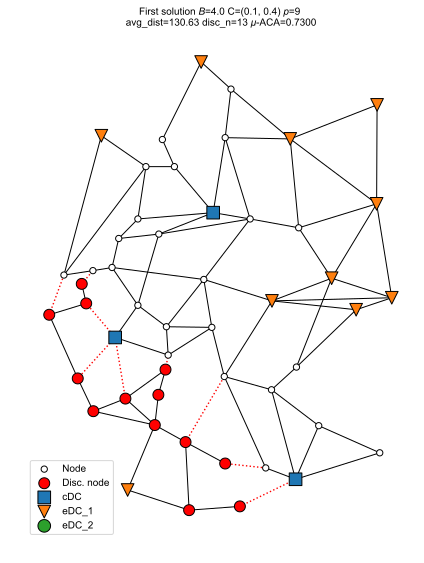

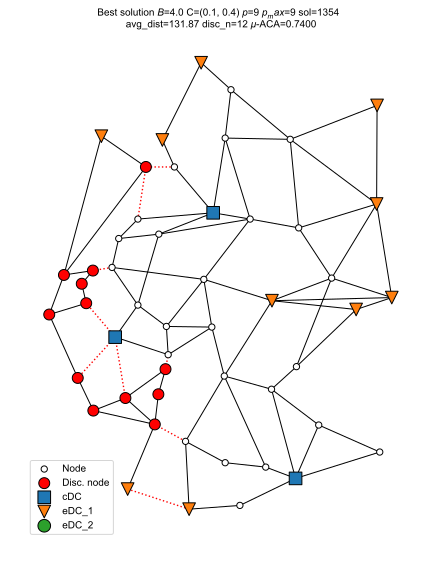

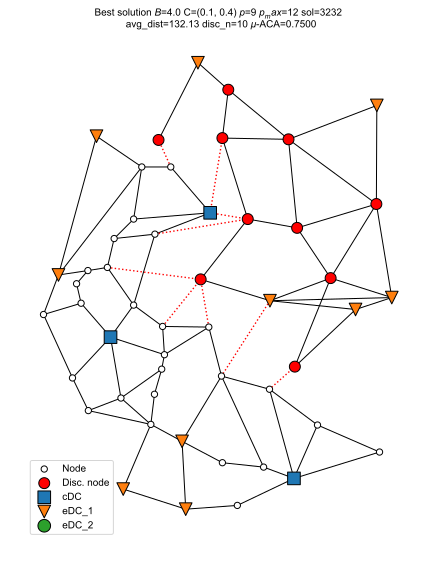

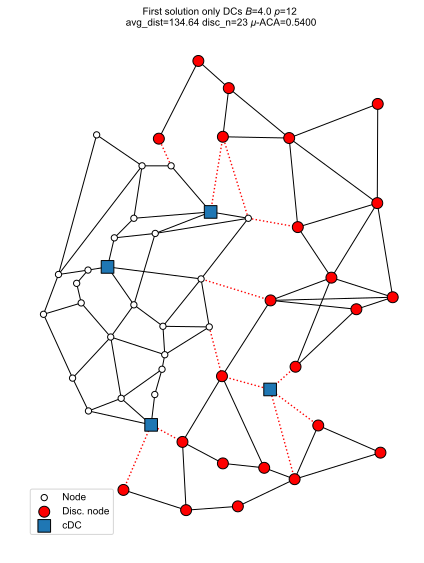

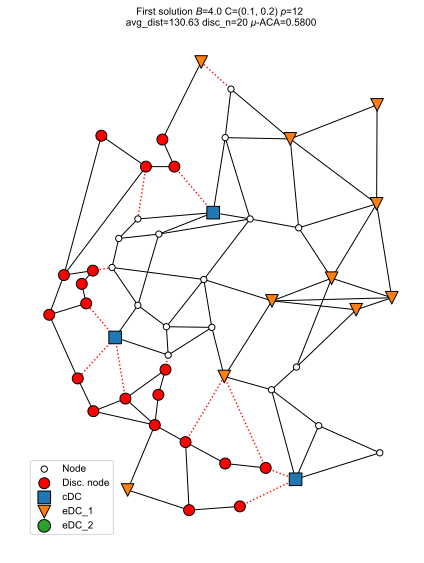

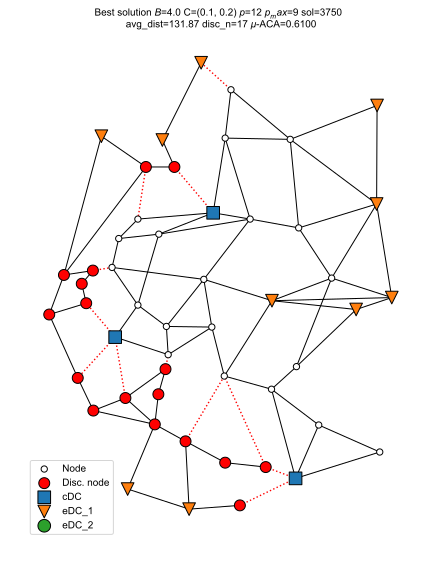

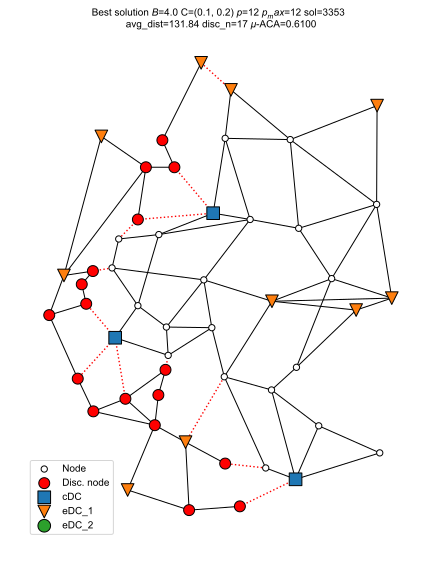

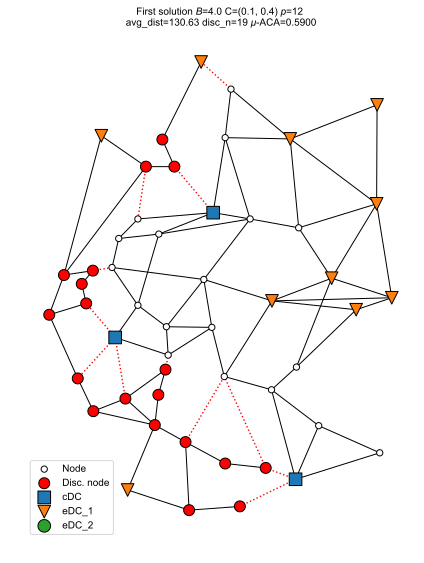

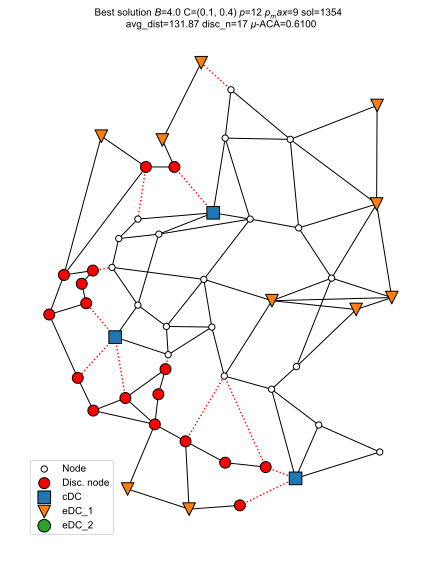

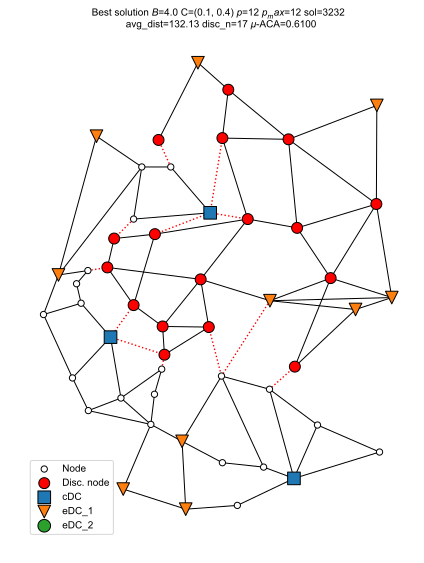

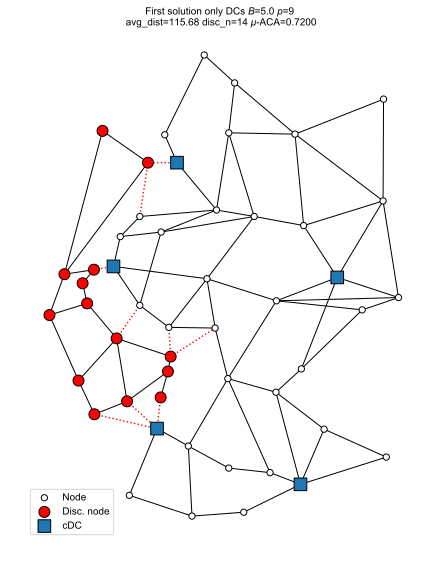

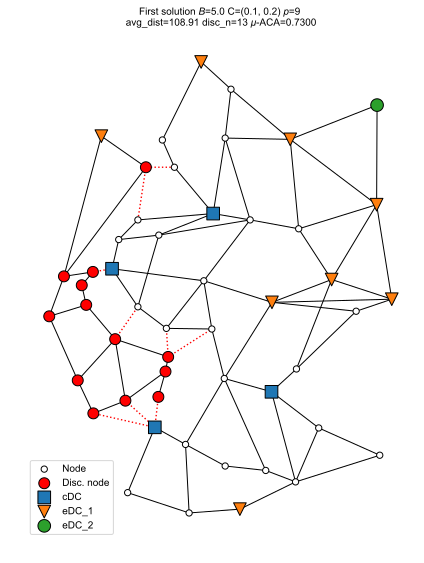

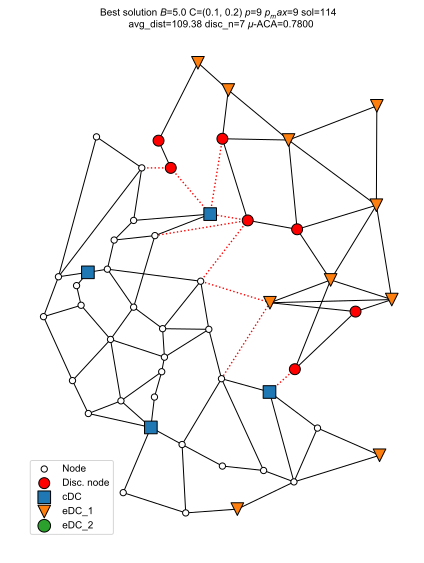

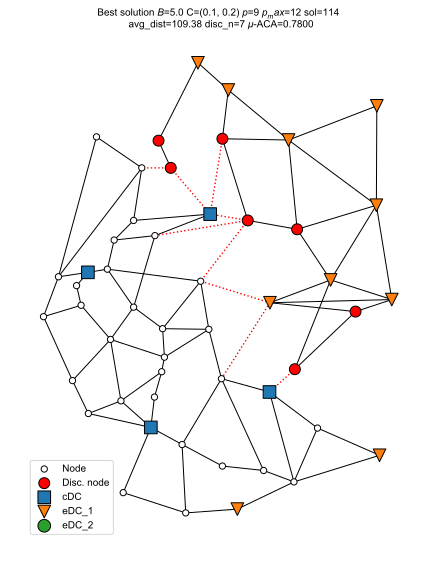

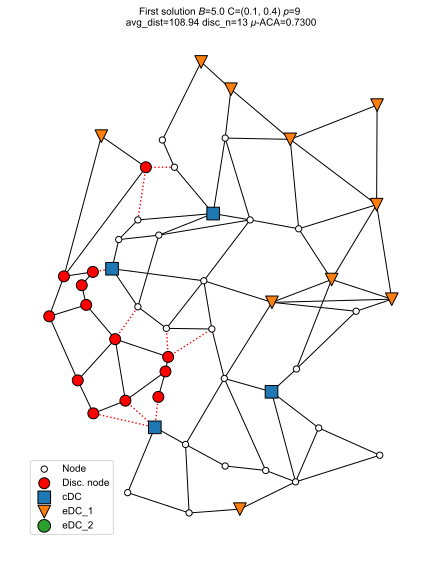

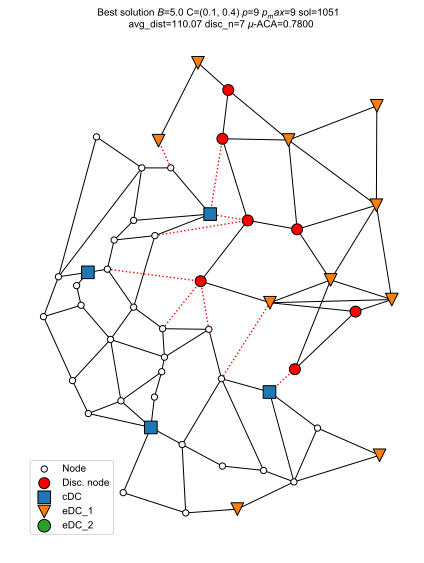

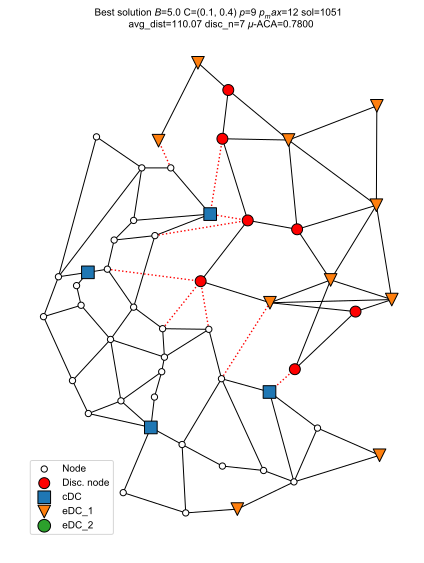

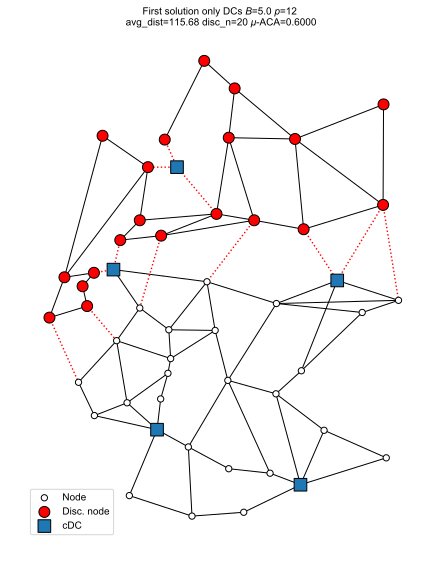

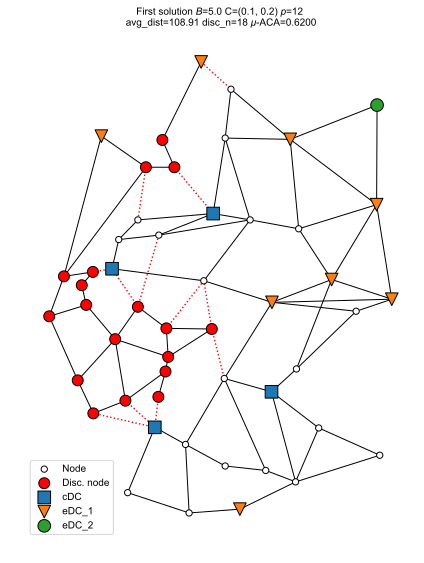

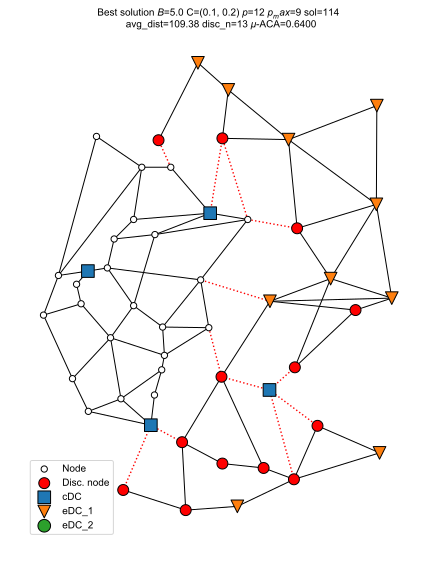

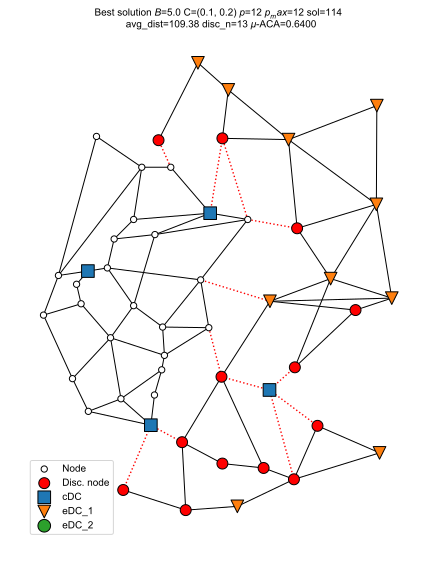

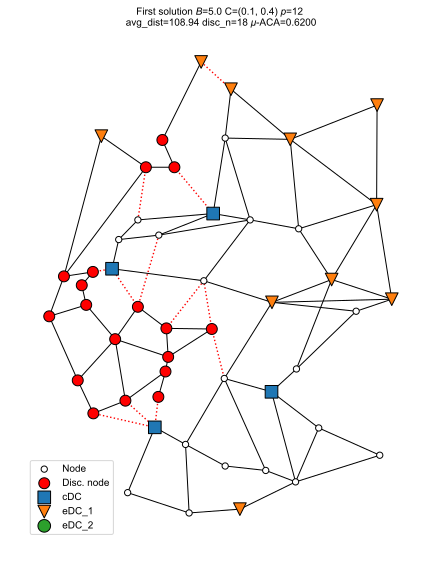

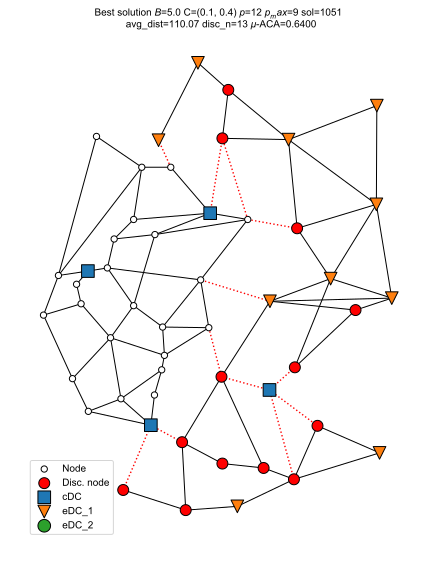

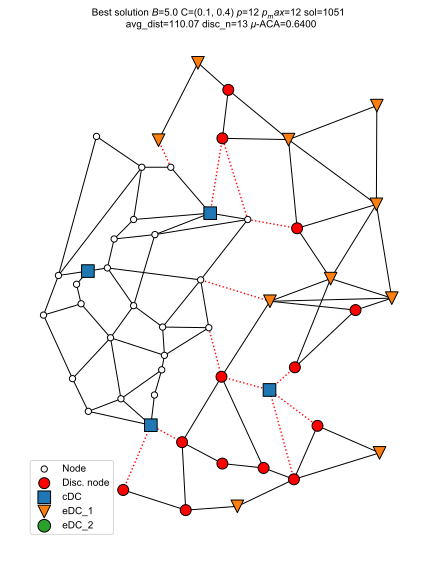

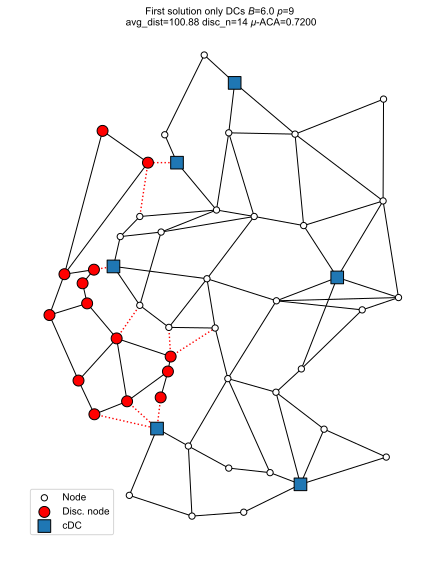

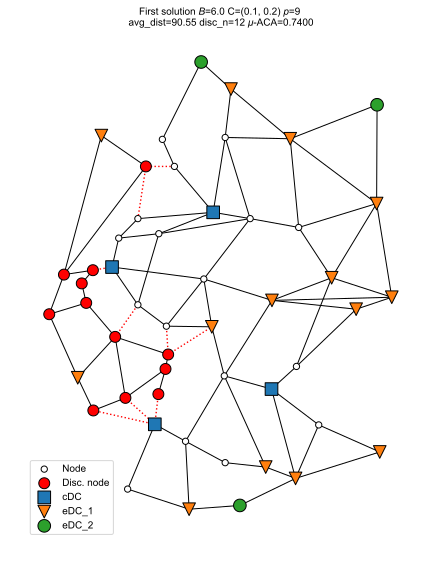

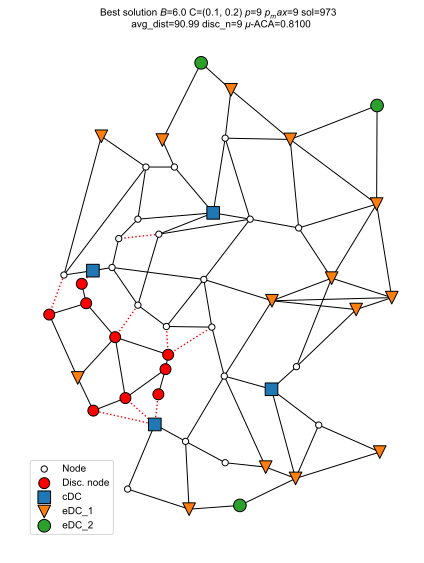

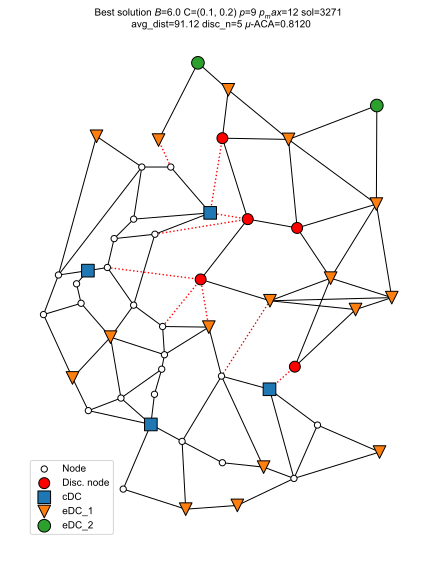

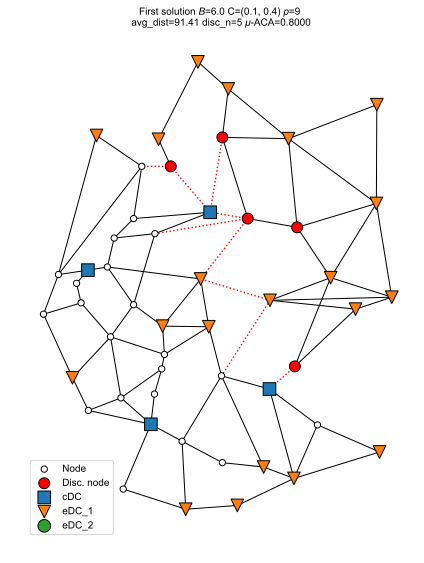

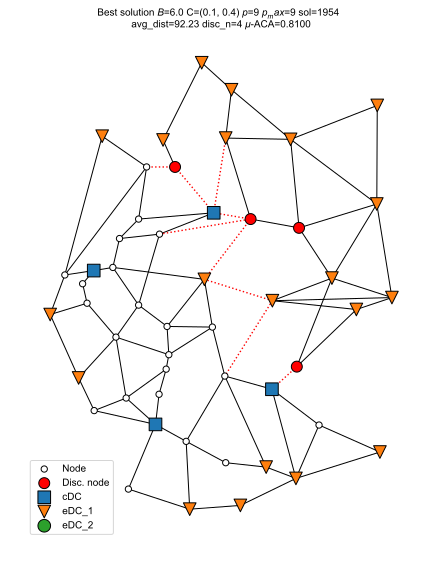

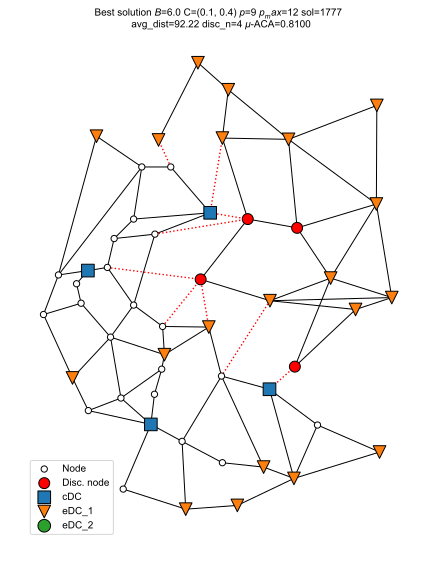

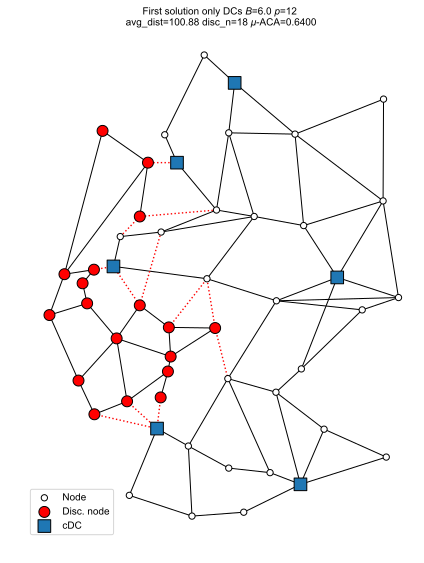

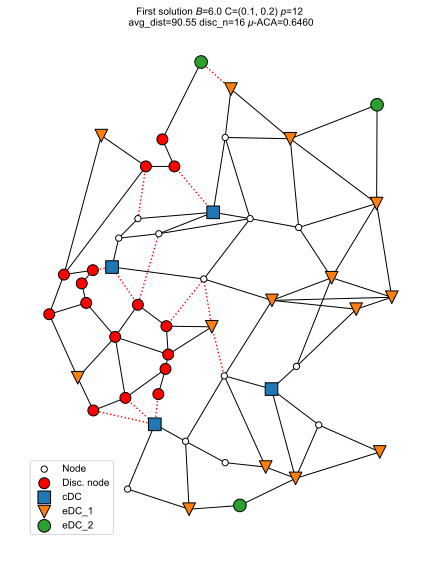

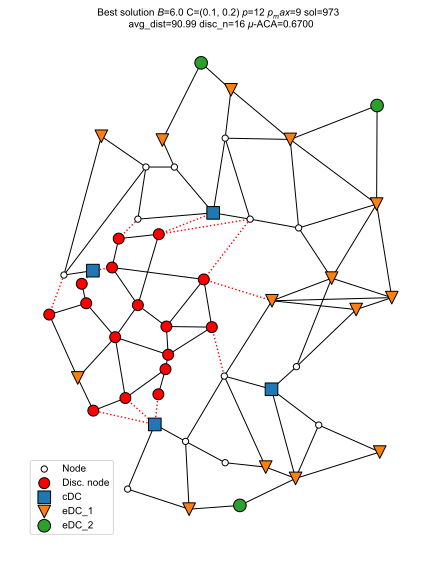

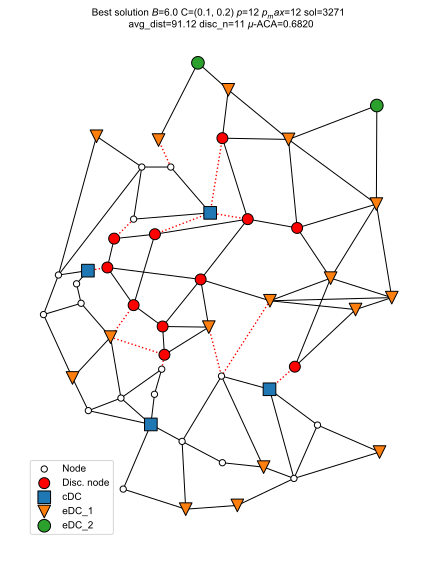

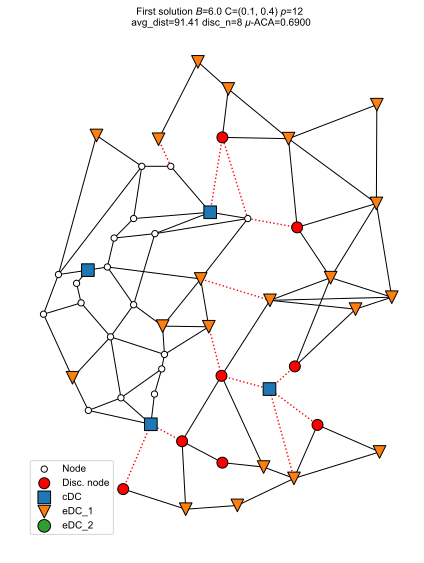

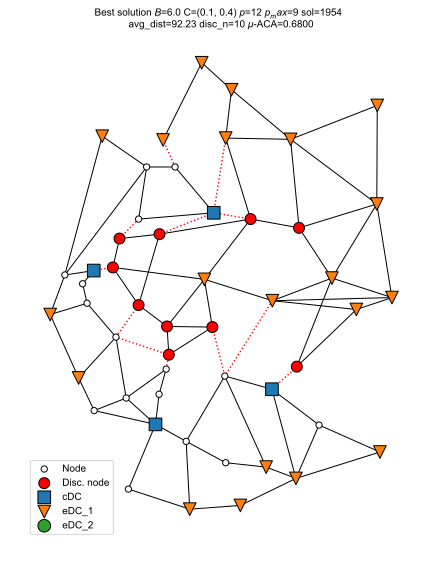

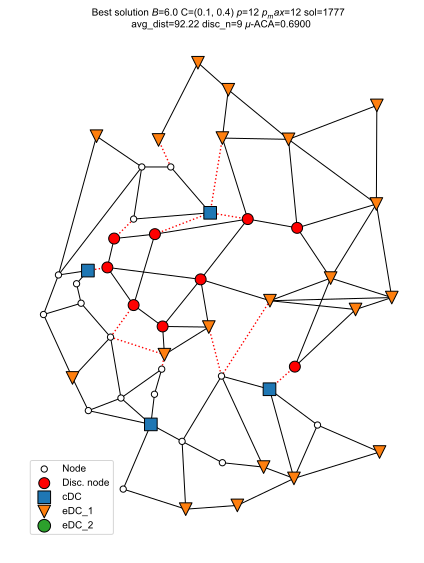

In [22]:
node_size = 160
critical_edge_style='dotted'
critical_edge_color='red'

for idb, budget in enumerate(budgets):#budgets
    
    for idp, p in enumerate(ps_of_interest[1:]):#budgets
        
        plt.figure(figsize=fig_size[topology])
        plt.axis('off')

        pos = nx.get_node_attributes(graph, 'pos')
        solution_cpp = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)].iloc[0]
            
        solution_clsd = data_clsd_only_dcs[(data_clsd_only_dcs['budget'] == budget) 
                              & (data_clsd_only_dcs['p'] == p)].iloc[0]
        plt.title('First solution only DCs $B$={} $p$={} \navg_dist={:.2f} disc_n={} $\mu$-ACA={:.4f}'.format(budget, 
                                                                                                     p, 
                                                                                                     solution_cpp['avg_distance'], 
                                                                                                     np.sum([1 for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]),
                                                                                                     solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])
        edges = [x for x in graph.edges()]
        critical_edges = []
        for index in range(p):
            edges.remove((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))
            critical_edges.append((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))
            
        nx.draw_networkx_edges(graph, pos, edgelist=edges)
        nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, style='dotted', edge_color='red', width=1.4)
            
        # plotting transport nodes which are not critical
        # cn_X == 1 if the node still connected to a replica, 0 otherwise
        nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
        nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
        plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)
            
        # plotting transport nodes which are critical
        nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
        nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
        plt.scatter(nodes_x,
                       nodes_y, label='Disc. node', color='red', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 40.)

        # plotting non critical DCs
        nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
        nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
        plt.scatter(nodes_x, nodes_y, label='cDC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)
        plt.legend(loc=3)
        plt.tight_layout()
#         plt.savefig('./figures/topology-' + topology + '-only-DCs-B_' + str(budget) + '-p_' + str(p) + '-first.' + figure_format)
        plt.show()
        plt.close()
        
        for idc, cost_configuration in enumerate(cost_configurations[:2]):
    
            plt.figure(figsize=fig_size[topology])
            plt.axis('off')

            pos = nx.get_node_attributes(graph, 'pos')
            solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget) 
                              & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_cpp_full['cost_edc_2'] == cost_configuration[2])].iloc[0]
            
            solution_clsd = data_clsd_full[(data_clsd_full['budget'] == budget) 
                              & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                              & (data_clsd_full['p'] == p)].iloc[0]
            plt.title('First solution $B$={} C={} $p$={} \navg_dist={:.2f} disc_n={} $\mu$-ACA={:.4f}'.format(budget, cost_configuration[1:], p, solution_cpp['avg_distance'], 
                                                                                                     np.sum([1 for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]),
                                                                                                     solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])
            edges = [x for x in graph.edges()]
            critical_edges = []
            for index in range(p):
                edges.remove((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))
                critical_edges.append((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))
            
            nx.draw_networkx_edges(graph, pos, edgelist=edges)
            nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, style='dotted', edge_color='red', width=1.4)
            
            # plotting transport nodes which are not critical
            # cn_X == 1 if the node still connected to a replica, 0 otherwise
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
            plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)
            
            # plotting transport nodes which are critical
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
            plt.scatter(nodes_x,
                       nodes_y, label='Disc. node', color='red', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 40.)

            # plotting non critical DCs
            nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1]
            plt.scatter(nodes_x, nodes_y, label='cDC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

            plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1],
                       [pos[x][1] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1], label='eDC_1', color=colors[1], alpha=1., marker='v', linewidths=1., edgecolors='black', s=node_size)

            plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1],
                       [pos[x][1] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1], label='eDC_2', color=colors[2], alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size)
            plt.legend(loc=3)
            plt.tight_layout()
#             plt.savefig('./figures/topology-' + topology + '-full-B_' + str(budget) + '-C_' + str(cost_configuration[1:]).replace(',', '_').replace('(', '-').replace(')', '-') + '-p_' + str(p) + '-first.' + figure_format)
            plt.show()
            plt.close()
            
            for idpmax, pmax in enumerate(ps_of_interest[1:]):#ps_of_interest
            
                plt.figure(figsize=fig_size[topology])
                plt.axis('off')

                pos = nx.get_node_attributes(graph, 'pos')
                solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget) 
                                  & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                  & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                  & (data_cpp_full['cost_edc_2'] == cost_configuration[2])
                                  & (data_cpp_full['id_solution'] == best_solutions_full[budget][cost_configuration][pmax])].iloc[0]

                solution_clsd = data_clsd_full[(data_clsd_full['budget'] == budget) 
                                  & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                                  & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                                  & (data_clsd_full['cost_edc_2'] == cost_configuration[2]) 
                                  & (data_clsd_full['p'] == p)
                                  & (data_clsd_full['id_solution'] == best_solutions_full[budget][cost_configuration][pmax])].iloc[0]
                plt.title('Best solution $B$={} C={} $p$={} $p_max$={} sol={}  \navg_dist={:.2f} disc_n={} $\mu$-ACA={:.4f}'.format(budget, cost_configuration[1:], p, pmax, best_solutions_full[budget][cost_configuration][pmax], solution_cpp['avg_distance'], 
                                                                                                                           np.sum([1 for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]),
                                                                                                                           solution_clsd['aca'] / num_nodes), fontsize=rcParams['font.size'])
                edges = [x for x in graph.edges()]
                critical_edges = []
                for index in range(p):
                    edges.remove((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))
                    critical_edges.append((str(int(solution_clsd['cl_i_' + str(index)])), str(int(solution_clsd['cl_j_' + str(index)]))))

                nx.draw_networkx_edges(graph, pos, edgelist=edges)
                nx.draw_networkx_edges(graph, pos, edgelist=critical_edges, style='dotted', edge_color='red', width=1.4)

                nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
                nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 1]
                plt.scatter(nodes_x, nodes_y, label='Node', color='white', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 120.)
            
                # plotting transport nodes which are critical
                nodes_x = [pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
                nodes_y = [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 0 and solution_cpp['edc_0_' + x] == 1 and solution_clsd['cn_' + x] == 0]
                plt.scatter(nodes_x,
                       nodes_y, label='Disc. node', color='red', alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size - 40.)
                
                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['dc_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['dc_' + x] == 1], label='cDC', color=colors[0], alpha=1., marker='s', linewidths=1., edgecolors='black', s=node_size)

                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['edc_1_' + x] == 1], label='eDC_1', color=colors[1], alpha=1., marker='v', linewidths=1., edgecolors='black', s=node_size)

                plt.scatter([pos[x][0] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1],
                           [pos[x][1] for x in graph.nodes() if solution_cpp['edc_2_' + x] == 1], label='eDC_2', color=colors[2], alpha=1., marker='o', linewidths=1., edgecolors='black', s=node_size)
                plt.legend(loc=3)
                plt.tight_layout()
#                 plt.savefig('./figures/topology-' + topology + '-full-B_' + str(budget) + '-C_' + str(cost_configuration[1:]).replace(',', '_').replace('(', '-').replace(')', '-') + '-p_' + str(p) + '-pmax_' + str(pmax) + '-best.' + figure_format)
                plt.show()
                plt.close()

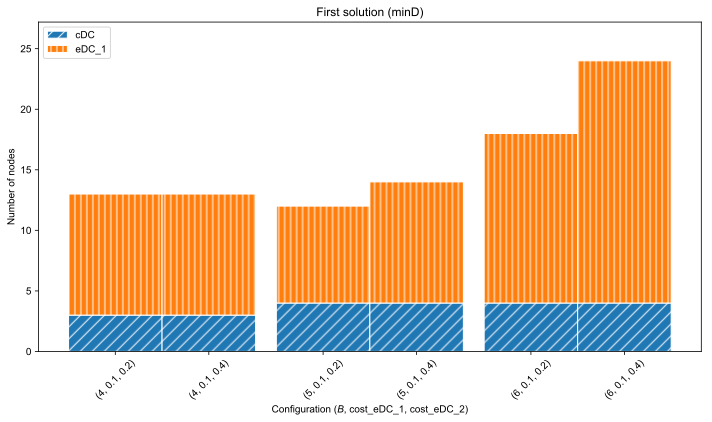

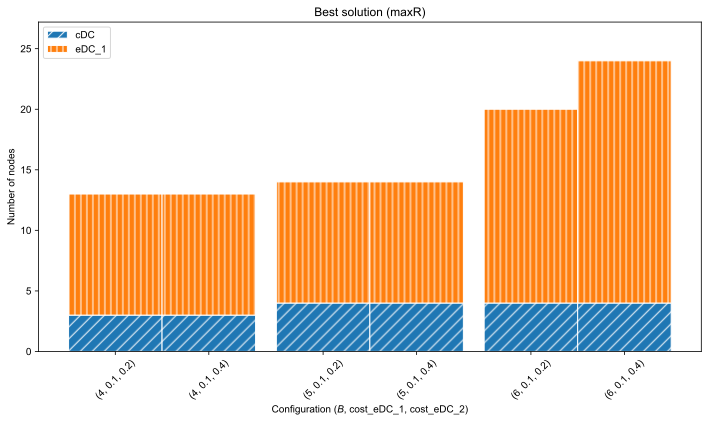

In [24]:
dc_columns = [x for x in data_cpp_full.columns if x.startswith('dc_')]
p_max = 12

number_nodes_first = {}
number_nodes_best = {}
legend_values = []
legend_text = []
values_first_plot = np.zeros((len(budgets) * len(cost_configurations), len(cost_configurations)))
values_best_plot = np.zeros((len(budgets) * len(cost_configurations), len(cost_configurations)))
bar_width = .9 / len(cost_configurations)

for idb, budget in enumerate(budgets):
    number_nodes_first[budget] = {}
    number_nodes_best[budget] = {}
    for idc, cost_configuration in enumerate(cost_configurations):
        legend_values.append(budget + ((idc - 1) * bar_width))
        legend_text.append('(' + str(int(budget)) + ', ' + str(cost_configuration[1]) + ', ' + str(cost_configuration[2]) + ')')

        number_nodes_first[budget][cost_configuration] = np.zeros(len(cost_configurations))
        number_nodes_best[budget][cost_configuration] = np.zeros(len(cost_configurations))
        sum_dcs = data_cpp_full[(data_cpp_full['budget'] == budget)
                               & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                               & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                               & (data_cpp_full['cost_edc_2'] == cost_configuration[2])].iloc[0][dc_columns].sum()
        number_nodes_first[budget][cost_configuration][0] = sum_dcs
        values_first_plot[idc + (len(cost_configurations) * idb), 0] = sum_dcs
        
        sum_dcs = data_cpp_full[(data_cpp_full['budget'] == budget)
                               & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                               & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                               & (data_cpp_full['cost_edc_2'] == cost_configuration[2])
                               & (data_cpp_full['id_solution'] == best_solutions_full[budget][cost_configuration][p_max])].iloc[0][dc_columns].sum()
        number_nodes_best[budget][cost_configuration][0] = sum_dcs
        values_best_plot[idc + (len(cost_configurations) * idb), 0] = sum_dcs
        
        sum_cost_configurations = np.zeros(len(cost_configurations) - 1)
        for i in range(1, len(cost_configurations)):
            edc_columns = [x for x in data_cpp_full.columns if x.startswith('edc_' + str(i))]
            sum_edcs = data_cpp_full[(data_cpp_full['budget'] == budget)
                                            & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                            & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                            & (data_cpp_full['cost_edc_2'] == cost_configuration[2]) ].iloc[0][edc_columns].sum()
            number_nodes_first[budget][cost_configuration][i] = sum_edcs
            values_first_plot[idc + (len(cost_configurations) * idb), i] = sum_edcs
            
            sum_edcs = data_cpp_full[(data_cpp_full['budget'] == budget)
                                            & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                                            & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                                            & (data_cpp_full['cost_edc_2'] == cost_configuration[2])
                                    & (data_cpp_full['id_solution'] == best_solutions_full[budget][cost_configuration][p_max])].iloc[0][edc_columns].sum()
            number_nodes_best[budget][cost_configuration][i] = sum_edcs
            values_best_plot[idc + (len(cost_configurations) * idb), i] = sum_edcs

hatches = ['//', '||', '\\\\']


node_types = ['cDC', 'eDC_1', 'eDC_2']

plt.figure(figsize=(fig_size_plots[0], fig_size_plots[1]))
plt.grid(True)
for i in range(0, len(cost_configurations)):
    bottom = np.zeros(len(values_first_plot[:, i]))
    if i > 0:
        bottom = np.sum(values_first_plot[:, :i], axis=1)
    plt.bar(legend_values, values_first_plot[:, i], width=bar_width, bottom=bottom, label=node_types[i], hatch=hatches[i], edgecolor='white')
plt.xlabel('Configuration ($B$, cost_eDC_1, cost_eDC_2)')
plt.ylabel('Number of nodes')
plt.title('First solution (minD)')
plt.legend(loc=2)
plt.xticks(legend_values, legend_text, rotation=45)
plt.ylim([plt.ylim()[0], plt.ylim()[1] + 2])
plt.grid(False)
plt.tight_layout()
# plt.savefig('./figures/' + topology + '_node_distribution_first.' + figure_format)
plt.show()
plt.close()

plt.figure(figsize=(fig_size_plots[0], fig_size_plots[1]))
for i in range(0, len(cost_configurations)):
    bottom = np.zeros(len(values_best_plot[:, i]))
    if i > 0:
        bottom = np.sum(values_best_plot[:, :i], axis=1)
    plt.bar(legend_values, values_best_plot[:, i], width=bar_width, bottom=bottom, label=node_types[i], hatch=hatches[i], edgecolor='white')
plt.xlabel('Configuration ($B$, cost_eDC_1, cost_eDC_2)')
plt.ylabel('Number of nodes')
plt.ylim([plt.ylim()[0], plt.ylim()[1] + 2])
plt.grid(False)
plt.title('Best solution (maxR)')
plt.legend(loc=2)

# plt.xlabel('Config.')
locs, _ = plt.xticks(legend_values, legend_text, rotation=45)
plt.tight_layout()
# plt.savefig('./figures/' + topology + '_node_distribution_best.' + figure_format)
plt.show()
plt.close()

## Computing the network capacity required by the solutions

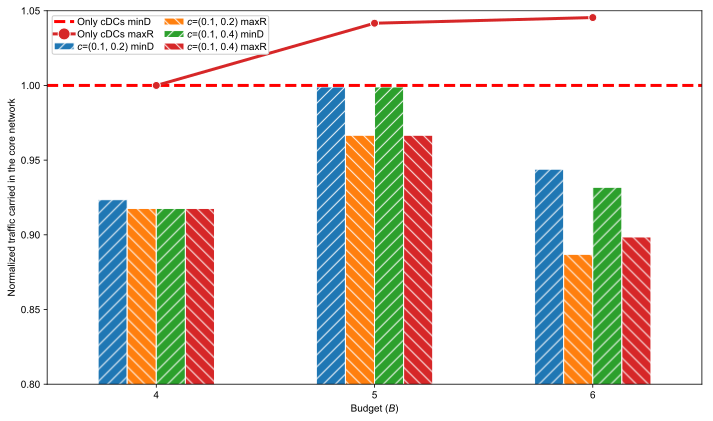

In [28]:
dc_columns = [x for x in data_cpp_full.columns if x.startswith('dc_')]

capacity_dc_only_first = {} # capacity required by the solution that places only full DCs
capacity_dc_only_best = {} # capacity required by the solution that places only full DCs
capacity_first = {} # capacity required by the first (best distance) solution
capacity_best = {} # capacity required by the best \mu-ACA solution
p_max = 12

for idb, budget in enumerate(budgets):
    
    solution_cpp = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)  
                                            & (data_cpp_only_dcs['id_solution'] == 0)].iloc[0]
    
    temp_graph = graph.copy()
    dcs = []
    for x in temp_graph.nodes():
        if solution_cpp['dc_' + x] == 1:
            temp_graph.nodes[x]['dc'] = True
            dcs.append(x)
    
    sum_length = 0.0
    sum_hops = 0.0
    for x in temp_graph.nodes():
        if 'dc' not in temp_graph.nodes[x]: # node is not a DC
            shortest = np.finfo(0.0).max
            hops = 0
            for dc in dcs:
                length = nx.shortest_path_length(temp_graph, x, dc, weight='weight')
                if length < shortest:
                    shortest = length
                    hops = len(nx.shortest_path(temp_graph, x, dc)) - 1
            sum_length += float(length)
            sum_hops += float(hops)

    capacity_dc_only_first[budget] = sum_hops
    
    solution_cpp = data_cpp_only_dcs[(data_cpp_only_dcs['budget'] == budget)  
                                            & (data_cpp_only_dcs['id_solution'] == best_solution_only_dcs[budget][p_max])].iloc[0]
    
    temp_graph = graph.copy()
    dcs = []
    for x in temp_graph.nodes():
        if solution_cpp['dc_' + x] == 1:
            temp_graph.nodes[x]['dc'] = True
            dcs.append(x)
    
    sum_length = 0.0
    sum_hops = 0.0
    for x in temp_graph.nodes():
        if 'dc' not in temp_graph.nodes[x]: # node is not a DC
            shortest = np.finfo(0.0).max
            hops = 0
            for dc in dcs:
                length = nx.shortest_path_length(temp_graph, x, dc, weight='weight')
                if length < shortest:
                    shortest = length
                    hops = len(nx.shortest_path(temp_graph, x, dc)) - 1
            sum_length += float(length)
            sum_hops += float(hops)

    capacity_dc_only_best[budget] = sum_hops
    
    
    capacity_first[budget] = {}
    capacity_best[budget] = {}
    for idc, cost_configuration in enumerate(cost_configurations):
        
        capacity_first[budget][cost_configuration] = 0.0
        capacity_best[budget][cost_configuration] = 0.0
        
        solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget)
                               & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                               & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                               & (data_cpp_full['cost_edc_2'] == cost_configuration[2])].iloc[0]
    
        temp_graph = graph.copy()
        dcs = []
        for x in temp_graph.nodes():
            if solution_cpp['dc_' + x] == 1:
                temp_graph.nodes[x]['dc'] = True
                dcs.append(x)
            elif solution_cpp['edc_1_' + x] == 1:
                temp_graph.nodes[x]['edc_1'] = True
            elif solution_cpp['edc_2_' + x] == 1:
                temp_graph.nodes[x]['edc_2'] = True
                
        sum_length = 0.0
        sum_hops = 0.0
        for x in temp_graph.nodes():
            if 'dc' not in temp_graph.nodes[x]: # and 'edc_1' not in temp_graph.nodes[x] and 'edc_2' not in temp_graph.nodes[x]: # node is not a DC and not an EDC
                shortest = np.finfo(0.0).max
                hops = 0
                for dc in dcs:
                    length = nx.shortest_path_length(temp_graph, x, dc, weight='weight')
                    if length < shortest:
                        shortest = length
                        hops = len(nx.shortest_path(temp_graph, x, dc)) - 1

                multiplier = 1.
                if 'edc_1' in temp_graph.nodes[x]:
                    multiplier = .5
                elif 'edc_2' in temp_graph.nodes[x]:
                    multiplier = .2

                sum_length += multiplier * float(length)
                sum_hops += multiplier * float(hops)

        capacity_first[budget][cost_configuration] = sum_hops

        solution_cpp = data_cpp_full[(data_cpp_full['budget'] == budget)
                               & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                               & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                               & (data_cpp_full['cost_edc_2'] == cost_configuration[2])
                               & (data_cpp_full['id_solution'] == best_solutions_full[budget][cost_configuration][p_max])].iloc[0]
    
        temp_graph = graph.copy()
        dcs = []
        for x in temp_graph.nodes():
            if solution_cpp['dc_' + x] == 1:
                temp_graph.nodes[x]['dc'] = True
                dcs.append(x)
            elif solution_cpp['edc_1_' + x] == 1:
                temp_graph.nodes[x]['edc_1'] = True
            elif solution_cpp['edc_2_' + x] == 1:
                temp_graph.nodes[x]['edc_2'] = True
                
        sum_length = 0.0
        sum_hops = 0.0
        for x in temp_graph.nodes():
            if 'dc' not in temp_graph.nodes[x]: # and 'edc_1' not in temp_graph.nodes[x] and 'edc_2' not in temp_graph.nodes[x]: # node is not a DC and not an EDC
                shortest = np.finfo(0.0).max
                hops = 0
                for dc in dcs:
                    length = nx.shortest_path_length(temp_graph, x, dc, weight='weight')
                    if length < shortest:
                        shortest = length
                        hops = len(nx.shortest_path(temp_graph, x, dc)) - 1

                multiplier = 1.
                if 'edc_1' in temp_graph.nodes[x]:
                    multiplier = .5
                elif 'edc_2' in temp_graph.nodes[x]:
                    multiplier = .2

                sum_length += multiplier * float(length)
                sum_hops += multiplier * float(hops)
        capacity_best[budget][cost_configuration] = sum_hops

hatches = ['//', '\\\\', '\\\\']

plt.figure(figsize=(fig_size_plots[0], fig_size_plots[1]))
plt.grid(True)

bar_width = .8 / (len(budgets) * 2)

for idc, cost_configuration in enumerate(cost_configurations):
    plt.bar([i + (((idc * 2.) - 1.5) * bar_width) for i in range(len(budgets))], 
            np.array([capacity_first[budget][cost_configuration] for budget in budgets]) / np.array([capacity_dc_only_first[budget] for budget in budgets]), 
            width=bar_width, edgecolor='white', label='$c$=(' + str(cost_configuration[1]) + ', ' + str(cost_configuration[2]) + ') minD', hatch=hatches[0])
    
    plt.bar([i + ((((idc * 2) + 1) - 1.5) * bar_width) for i in range(len(budgets))], 
            np.array([capacity_best[budget][cost_configuration] for budget in budgets]) / np.array([capacity_dc_only_best[budget] for budget in budgets]), 
            width=bar_width, edgecolor='white', label='$c$=(' + str(cost_configuration[1]) + ', ' + str(cost_configuration[2]) + ') maxR', hatch=hatches[1])

plt.plot(range(-1, 4), np.tile(1., 5), color='white', linewidth=4.)
plt.plot(range(-1, 4), np.tile(1., 5), label='Only cDCs minD', color='red', linewidth=3., linestyle='--')

plt.plot(range(3), 
         np.array([capacity_dc_only_best[budget] for budget in budgets]) / np.array([capacity_dc_only_first[budget] for budget in budgets]), 
         label='Only cDCs maxR', marker='o', color=colors[3], markeredgecolor='white', linewidth=3., markersize=8)

plt.xlabel('Budget ($B$)')
plt.ylabel('Normalized traffic carried in the core network')

plt.legend(loc=2, ncol=2, framealpha=1., markerscale=1.5, borderpad=0.2, labelspacing=0.3, handletextpad=0.3, columnspacing=1.0)
plt.xticks(range(len(budgets)), [int(budget) for budget in budgets])
plt.ylim([0.8, 1.05])
plt.xlim([-.5, 2.5])
plt.grid(False)
plt.tight_layout()
# plt.savefig('./figures/' + topology + '_capacity.' + figure_format)
plt.show()
plt.close()

### Absolute values with eDCs

/home/carda/.conda/envs/venv37-tf13-cpu/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


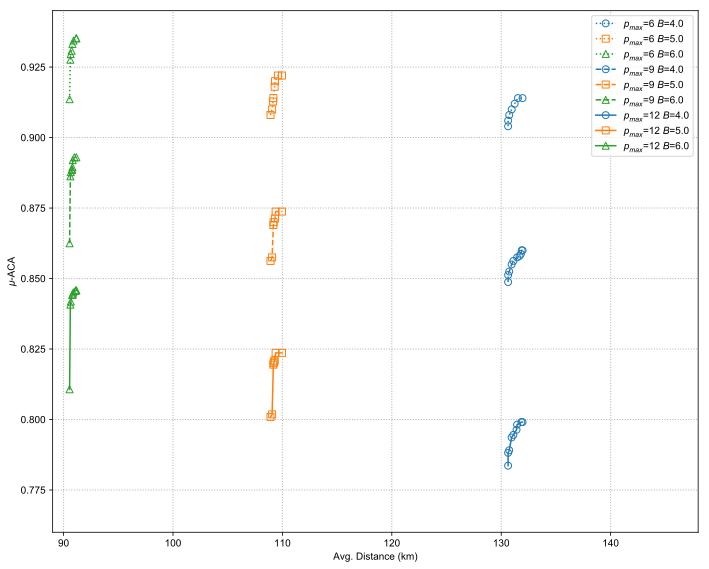

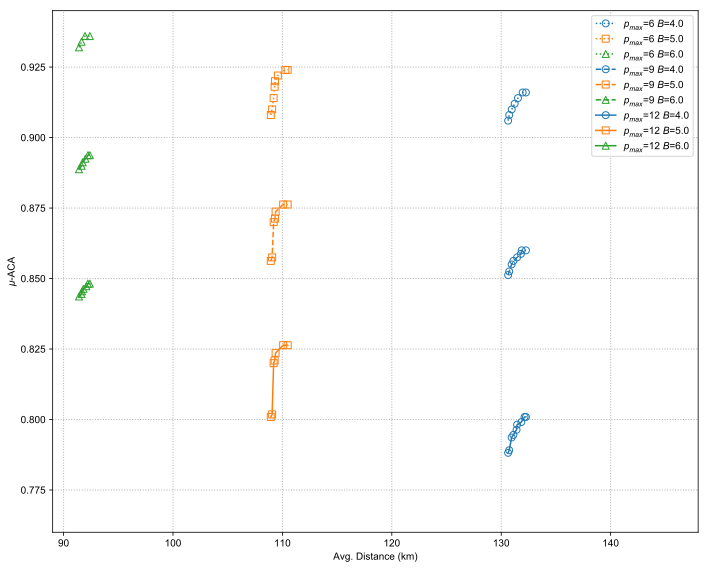

In [29]:
for idc, cost_configuration in enumerate(cost_configurations):
    plt.figure(figsize=(10, 8))

    plt.xlabel('Avg. Distance (km)')
    plt.ylabel('$\mu$-ACA')
    for i, p in enumerate(ps_of_interest):
        for j, budget in enumerate(budgets):
            line_plot, = plt.plot(points_x_full[budget][cost_configuration][p], np.array(points_y_full[budget][cost_configuration][p]) / num_nodes, label='$p_{max}$=' + str(p) + ' $B$=' + str(budget), linestyle=lines[i], linewidth=1.5, marker=markers[j], color=colors[j], markerfacecolor='none')
    
    handles = []

    handles.append(mlines.Line2D([], [], label='$B$=6', marker=markers[2], color=colors[2], linestyle='none', markerfacecolor='none'))
    handles.append(mlines.Line2D([], [], label='$B$=5', marker=markers[1], color=colors[1], linestyle='none', markerfacecolor='none'))
    handles.append(mlines.Line2D([], [], label='$B$=4', marker=markers[0], color=colors[0], linestyle='none', markerfacecolor='none'))

    handles.append(mlines.Line2D([], [], label='$\mathrm{p_{max}=6}$', linestyle=lines[0], linewidth=2.0, color='black'))
    handles.append(mlines.Line2D([], [], label='$\mathrm{p_{max}=9}$', linestyle=lines[1], linewidth=2.0, color='black'))
    handles.append(mlines.Line2D([], [], label='$\mathrm{p_{max}=12}$', linestyle=lines[2], linewidth=2.0, color='black'))

    plt.axes().grid(linestyle=':', linewidth=1.)
    
    if topology == 'Coronet':
        plt.xlim([460, 710])
        
    if topology == 'Germany50':
        plt.xlim([89, 148])
        plt.ylim([.76, .945])
    plt.legend()
    plt.tight_layout()
    
#     plt.savefig('./figures/frontier-budget-' + topology + '-full' + str(cost_configuration[1:]).replace(', ', '-').replace('.', '').replace('(', '-').replace(')', '') + '.' + figure_format)
    plt.show()
    plt.close()

### Absolute values without eDCs

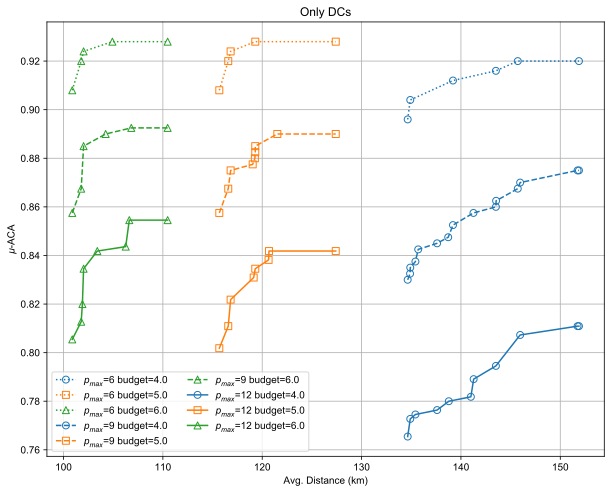

In [30]:
plt.figure(figsize=(10, 8))

plt.title('Only DCs')
plt.xlabel('Avg. Distance (km)')
plt.ylabel('$\mu$-ACA')
for i, p in enumerate(ps_of_interest):
    for j, budget in enumerate(budgets):
        plt.plot(points_x_only_dcs[budget][p], np.array(points_y_only_dcs[budget][p]) / num_nodes, label='$p_{max}$=' + str(p) + ' budget=' + str(budget), linestyle=lines[i], linewidth=1.5, marker=markers[j], color=colors[j], markerfacecolor='none')
plt.grid(True)
plt.legend(loc=3, ncol=2)
# plt.savefig('./figures/frontier-budget-' + topology + '-only-dcs.' + figure_format)
plt.show()
plt.close()

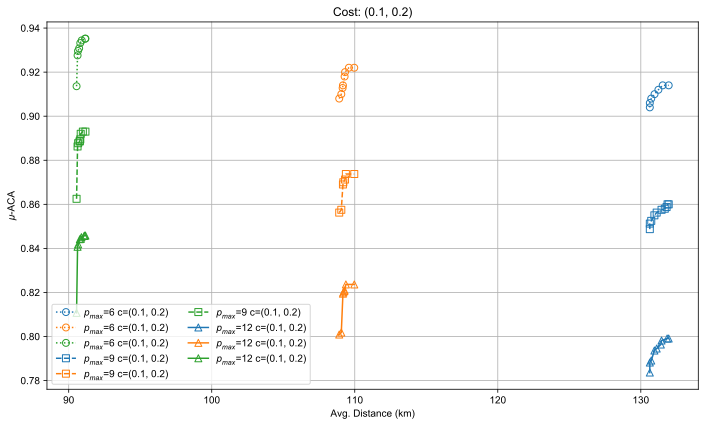

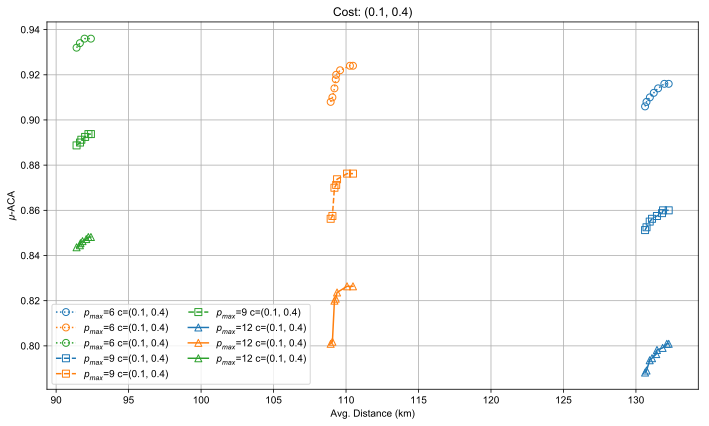

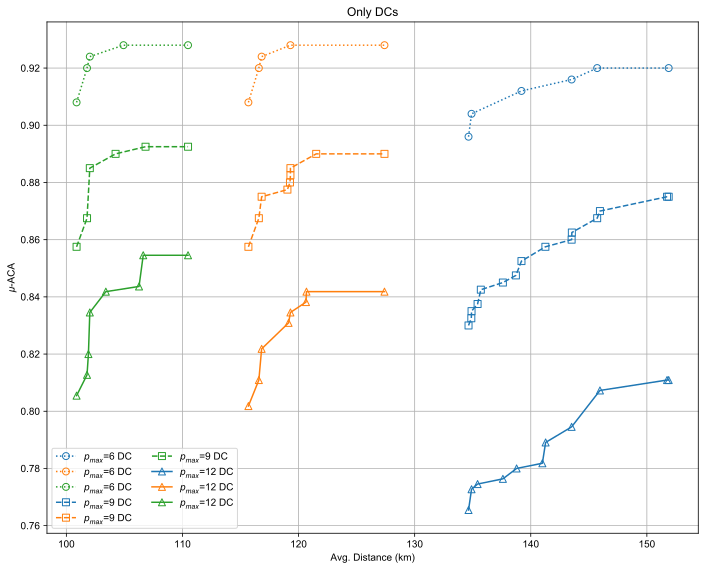

In [11]:
for idc, cost_configuration in enumerate(cost_configurations):
    plt.figure(figsize=fig_size_plots)
    plt.title('Cost: {}'.format(cost_configuration[1:]))
    plt.xlabel('Avg. Distance (km)')
    plt.ylabel('$\mu$-ACA')
    for idp, p in enumerate(ps_of_interest):
        for idb, budget in enumerate(budgets):
            plt.plot(points_x_full[budget][cost_configuration][p], np.array(points_y_full[budget][cost_configuration][p]) / num_nodes, label='$p_{max}$=' + str(p) + ' c=' + str(cost_configuration[1:]), linestyle=lines[idp], linewidth=1.5, marker=markers[idp], color=colors[idb], markerfacecolor='none')
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.savefig('./figures/frontier-budget-' + topology + '-full' + str(cost_configuration[1:]).replace(',', '_').replace('(', '-').replace(')', '') + '.eps')
    plt.show()
    plt.close()
    
plt.figure(figsize=(10, 8))
plt.title('Only DCs')
plt.xlabel('Avg. Distance (km)')
plt.ylabel('$\mu$-ACA')
for idp, p in enumerate(ps_of_interest):
    for idb, budget in enumerate(budgets):
        plt.plot(points_x_only_dcs[budget][p], np.array(points_y_only_dcs[budget][p]) / num_nodes, label='$p_{max}$=' + str(p) + ' DC', linestyle=lines[idp], linewidth=1.5, marker=markers[idp], color=colors[idb], markerfacecolor='none')
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./figures/frontier-budget-' + topology + '-only-dcs.' + figure_format)
plt.show()
plt.close()

### Running time CPP

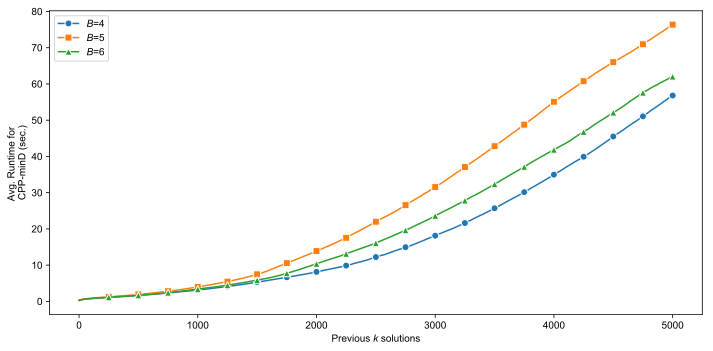

In [12]:
mean_values = {}
for idb, budget in enumerate(budgets):
    values = np.zeros((len(cost_configurations), max_solutions + 2))
    for idc, cost_configuration in enumerate(cost_configurations):
        df = data_cpp_full[(data_cpp_full['budget'] == budget)
                          & (data_cpp_full['cost_edc_0'] == cost_configuration[0]) 
                          & (data_cpp_full['cost_edc_1'] == cost_configuration[1]) 
                          & (data_cpp_full['cost_edc_2'] == cost_configuration[2])]['runtime']
        for k in range(0, len(df) + 1):
            values[idc][k] = np.mean(df[0:k])
    mean_values[budget] = np.mean(values, axis=0)

plt.figure(figsize=(fig_size_plots[0], fig_size_plots[1]-1))
for idb, budget in enumerate(budgets):
    plt.plot(np.array(mean_values[budget]) / 1000, label='$B$='+str(int(budget)), color=colors[idb], marker=markers[idb], markevery=250, markeredgecolor='white')
plt.xlabel('Previous $k$ solutions')
plt.ylabel('Avg. Runtime for \nCPP-minD (sec.)')
plt.grid(False)
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/runtime-cpp-' + topology + '-avg.' + figure_format)
plt.show()
plt.close()

### Running time CLSD

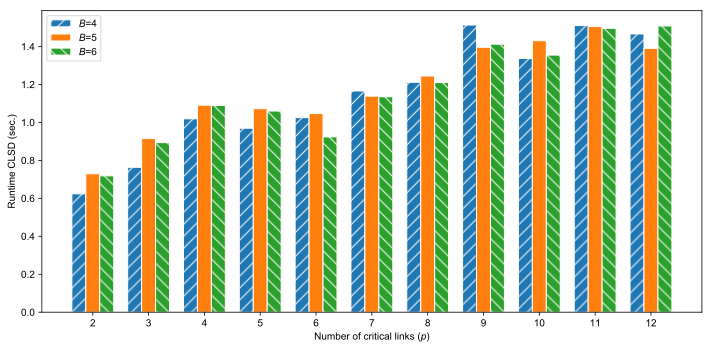

In [13]:
times = np.zeros((len(budgets), len(cost_configurations), len(ps)))
max_times = np.zeros((len(budgets), len(cost_configurations), len(ps)))
for idb, budget in enumerate(budgets):
    for idc, cost_configuration in enumerate(cost_configurations):
        for idp, p in enumerate(ps):
            df = data_clsd_full[(data_clsd_full['budget'] == budget)
                              & (data_clsd_full['cost_edc_0'] == cost_configuration[0]) 
                              & (data_clsd_full['cost_edc_1'] == cost_configuration[1]) 
                              & (data_clsd_full['cost_edc_2'] == cost_configuration[2])
                              & (data_clsd_full['p'] == p)]['runtime']
            times[idb][idc][idp] = df.mean()
            max_times[idb][idc][idp] = df.max()

bar_width = .75 / len(budgets)

hatches = ['//', '', '\\\\']
avg = np.mean(times[idb][:][:], axis=0)
plt.figure(figsize=(fig_size_plots[0], fig_size_plots[1]-1))
for idb, budget in enumerate(budgets):
    x = [p - 1. * bar_width + idb * bar_width for p in ps]
    plt.bar(x, np.mean(times[idb][:][:], axis=0) / 1000, width=bar_width, label='$B$='+str(int(budget)), color=colors[idb], edgecolor='white', hatch=hatches[idb])
plt.xticks(ps)
plt.xlabel('Number of critical links ($p$)')
plt.ylabel('Runtime CLSD (sec.)')
plt.legend()
plt.tight_layout()
# plt.savefig('./figures/runtime-clsd-' + topology + '-avg.' + figure_format)
plt.show()
plt.close()


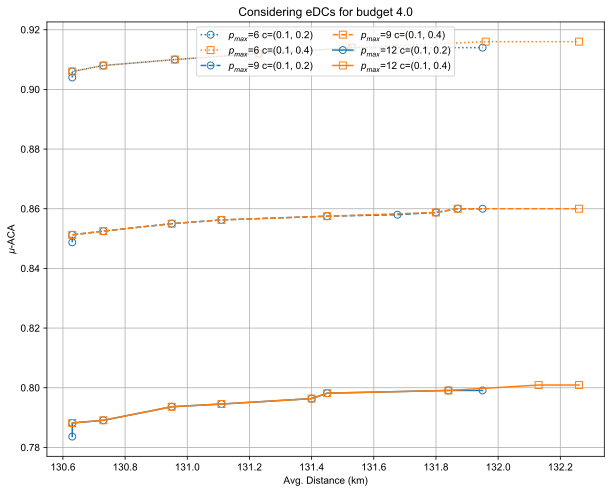

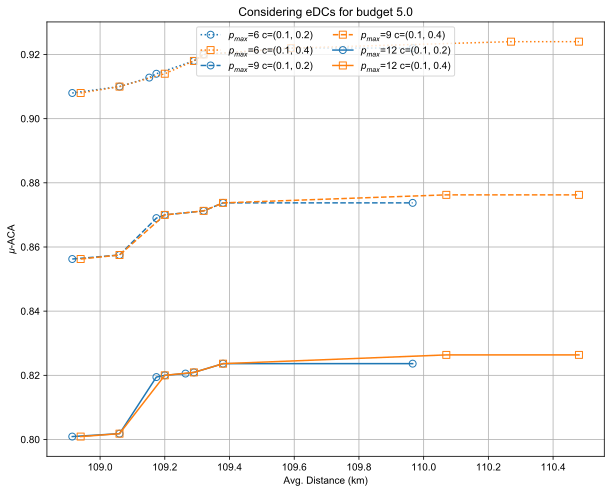

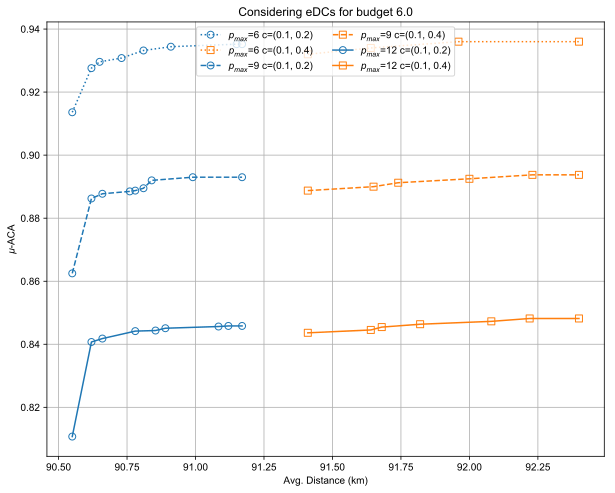

In [31]:
for idb, budget in enumerate(budgets):
    plt.figure(figsize=(10, 8))

    plt.title('Considering eDCs for budget ' + str(budget))
    plt.xlabel('Avg. Distance (km)')
    plt.ylabel('$\mu$-ACA')
    for i, p in enumerate(ps_of_interest):
        for j, cost_configuration in enumerate(cost_configurations):
            plt.plot(points_x_full[budget][cost_configuration][p], np.array(points_y_full[budget][cost_configuration][p]) / num_nodes, label='$p_{max}$=' + str(p) + ' c=' + str(cost_configuration[1:]), linestyle=lines[i], linewidth=1.5, marker=markers[j], color=colors[j], markerfacecolor='none')
    plt.grid(True)
    plt.legend(loc=9, ncol=2)
#     plt.savefig('./figures/frontier-setting-' + topology + '-full-' + str(budget) + '.' + figure_format)
    plt.show()
    plt.close()